In [1]:
#pip install voila
#pip install ipywidgets 
#pip install widgetsnbextension 
#!jupyter nbextension enable --py widgetsnbextension --sys-prefix
#!jupyter serverextension enable voila --sys-prefix

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import re
#from wordcloud import WordCloud

import ipywidgets as widgets
from IPython.display import display, clear_output
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

In [3]:
data= pd.read_csv("sentiment.csv", encoding="ansi")
data.head()

,tweet_id,label,tweet_text
0,1.360342e+18,1,"4,000 a day dying from the so called Covid-19 ..."
1,1.382896e+18,2,Pranam message for today manifested in Dhyan b...
2,1.375673e+18,2,Hyderabad-based ?@BharatBiotech? has sought fu...
3,1.381311e+18,1,"Confirmation that Chinese #vaccines ""don’t hav..."
4,1.362166e+18,3,"Lab studies suggest #Pfizer, #Moderna vaccines..."


In [4]:
data.shape

(33700, 3)

In [5]:
count = data['label'].values.tolist()
df_count = pd.DataFrame((pd.Series(count)).value_counts(), columns = ['Count'])

In [6]:
df_count

,Count
2,15553
3,12923
1,5224


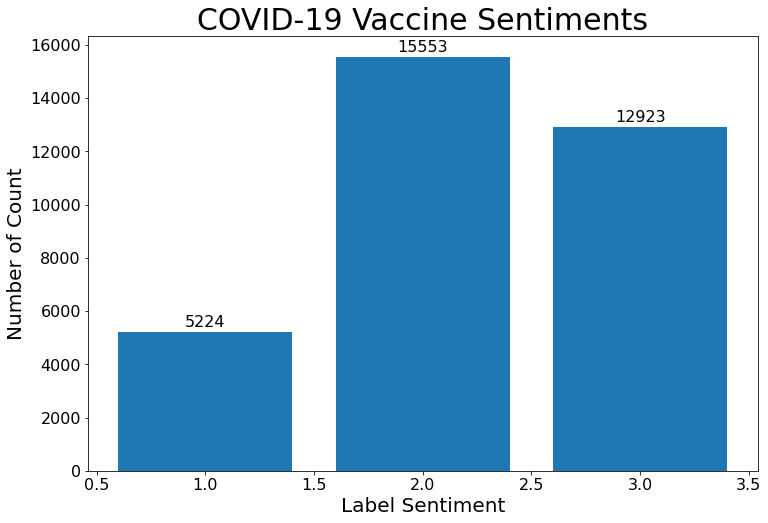

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,8))
plt.title("COVID-19 Vaccine Sentiments", fontdict = {'fontsize' : 30})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Label Sentiment", fontsize=20)
plt.ylabel("Number of Count", fontsize=20)

# zip joins x and y coordinates in pairs
for x,y in zip(df_count.index,df_count["Count"]):
    label = "{:}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center',
                 fontsize=16) # horizontal alignment can be left, right or center

plt.bar(df_count.index, height=df_count["Count"])
#plt.savefig("Figure/Barplot Users' Status", bbox_inches ="tight")
plt.show()


In [8]:
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as",
             "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could",
             "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had",
             "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him",
             "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's",
             "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or",
             "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll",
             "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them",
             "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've",
             "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll",
             "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while",
             "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've",
             "your", "yours", "yourself", "yourselves" ]

replace_puncts = {'`': "'", '′': "'", '“':'"', '”': '"', '‘': "'"}

strip_chars = [',', '.', '"', ':', ')', '(', '-', '|', ';', "'", '[', ']', '>', '=', '+', '\\', '•',  '~', '@', 
                '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′',
               'Â', '█', '½', 'à', '…', '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿',
               '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀',
               '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', 
               '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', 'ð', 'Ÿ',
              'ª', 'â', 'Ù', 'ƒ', '‰', 'š', '¥', 'ï']

puncts = ['!', '?', '$', '&', '/', '%', '#', '*','£']

In [9]:
 data['tweet_text'] = data['tweet_text'].str.lower()

In [10]:
#clean data function
def clean_data(x):
    x = str(x)
    
    for k, v in replace_puncts.items():
        x = x.replace(k, f' {v} ')
        
    for punct in strip_chars:
        x = x.replace(punct, ' ') 
    
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
        
    x = x.replace(" '", " ")
    x = x.replace("' ", " ")
    x = x.replace(" % ", " ")
        
    return x

#remove stopwords function
def remove_stopwords(x): 
    x['tweet_text Without Stopwords'] = x['tweet_text'].apply(lambda x : ' '.join([word for word in str(x).split() 
                                                                             if word not in (stopwords)]))

    return x

In [11]:
#remove stopwords from train, test and validation files
clean = remove_stopwords(data)

#remove punctuation, symbols, characters in all dataframes
clean['Final Text'] = clean['tweet_text Without Stopwords'].apply(clean_data)
clean.drop(clean.columns.difference(['Final Text','label']), axis=1, inplace=True)
clean = clean[['Final Text', 'label']]

In [12]:
clean.shape

(33700, 2)

In [13]:
clean.head()

,Final Text,label
0,4 000 day dying called covid 19 vaccine ...,1
1,pranam message today manifested dhyan meenapr...,2
2,hyderabad based ? bharatbiotech ? sought fu...,2
3,confirmation chinese # vaccines don t high p...,1
4,lab studies suggest # pfizer # moderna vacc...,3


In [14]:
data= pd.read_csv("sentiment_application.csv", encoding="ansi")
data.head()

,tweet_text,tweet_id,label,Score,sentiment
0,"4,000 a day dying from the so called Covid-19 ...",1.360342e+18,1.0,0.0,Neutral
1,Pranam message for today manifested in Dhyan b...,1.382896e+18,2.0,1.2,Positive
2,Hyderabad-based ?? has sought funds from the g...,1.375673e+18,2.0,0.0,Neutral
3,"Confirmation that Chinese vaccines ""don’t have...",1.381311e+18,1.0,-0.7,Negative
4,"Lab studies suggest Pfizer, Moderna vaccines c...",1.362166e+18,3.0,0.4,Positive


In [15]:
data.shape

(33207, 5)

In [16]:
#take input 

import ipywidgets
from IPython.display import display, clear_output

text =ipywidgets.Text(value = '',
                     placeholder = 'type here',
                     description = 'Input Tweet:', 
                     disable = False
                     )
instructions = ipywidgets.widgets.HTML('Enter your Tweet to analyse the Sentiment: ')
display(text)

def submit(greeting):
    print ('Your Input: {}'.format(text.value))
    
text.on_submit(submit)

Text(value='', description='Input Tweet:', placeholder='type here')

In [17]:
# Image Widget

import ipywidgets as widgets
from ipywidgets import AppLayout, Button, Layout

file = open("covid.jpg", "rb")
image = file.read()

image_headline=widgets.Image(value=image, format='jpg', width=500, height=400)

label_headline = widgets.Label(
                    value='Photo by WHO',
                    style={'description_width': 'initial'}
                )

vbox_headline = widgets.VBox([image_headline, label_headline])

In [18]:
# grandson/granddaughter

grand = widgets.ToggleButtons(
            options=['grandson', 'granddaughter']
        )

In [19]:
# name

name = widgets.Text(placeholder='Your name here')

#date

date = widgets.DatePicker(description='Pick a Date')

In [20]:
# number of friends

friends = widgets.IntSlider(
            value=3, # default value
            min=0, 
            max=10,
            step=1,
            style={'description_width': 'initial', 'handle_color': '#16a085'} 
        )

In [21]:
tokenizer = Tokenizer(num_words=5000)
#tokenizer.fit_on_texts(tweet)

In [22]:
# button send
from keras.preprocessing.text import Tokenizer


button_send = widgets.Button(
                description='Analyse the Tweet',
                tooltip='Send',
                style={'description_width': 'initial'}
            )

output = widgets.Output()

def on_button_clicked(event):
    with output:
        clear_output()
        print("Sent message: ")
        #print(f"Dear {name.value}.")
        #print(f"I would love to come over on {date.value} for dinner, if that's okay for you!")
        #print(f"Also, if you don't mind, I'll bring along {friends.value} hungry ghosts for your delicious food!")
        print(f"Your Tweets {textarea.value}.")
        print("Predicted label: ", predict_sentiment(textarea.value))
        
def predict_sentiment(tweet_text):
    model = Sequential()
    tw = tokenizer.texts_to_sequences([tweet_text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    print("Predicted label: ", sentiment[1][prediction])

button_send.on_click(on_button_clicked)

vbox_result = widgets.VBox([button_send, output])

In [23]:
textarea = widgets.Textarea(placeholder='Type something',
    description='Input:',
    disabled=False,
   width=500, height=200
)


In [24]:
# stacked right hand side

text_0 = widgets.HTML(value="<h1>Covid-19 Vaccine Sentiments Application!</h1>")
text_1 = widgets.HTML(value="<h2>This is your favourite</h2>")
#text_2= widgets.HTML(value="<h2>I would love to come over on </h2>")
#text_3= widgets.HTML(value="<h2>for dinner, if that's okay for you!</h2>")
#text_4= widgets.HTML(value="<h2>Also, if you don't mind, I'll bring along </h2>")
#text_5= widgets.HTML(value="<h2>hungry ghosts for dinner, if that's okay for you!</h2>")
text_6= widgets.HTML(value="<h2>Input Your Tweets: </h2>")
#text_7= widgets.HTML(value="<h2>")

vbox_text = widgets.VBox([text_0, text_1, text_6, textarea, vbox_result])

In [25]:
page = widgets.HBox([vbox_headline, vbox_text])
display(page)